In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor

from scipy.stats import randint, uniform

In [2]:
df_raw=pd.read_csv('car_insurance_claim.csv')
df_raw.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


**rename columns**

In [3]:
#df_raw.columns.to_list()
# Define updated column names
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

# Update column names
df_raw.rename(columns=col_names, inplace=True)

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

### 1. Basic Data Cleaning ###

In [5]:
# create a copy of the dataset
df=df_raw.copy()
df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,...,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


#### 1.1 Drop duplicates ####

In [6]:
# check number of duplicate columns
df.duplicated().sum()

1

In [7]:
# drop duplicate data
df.drop_duplicates();

#### 1.2 Clean columns with typos and such ####
*remove '$' and ',' from currency based columns*

In [8]:
# define currency columns 
currency_cols=['income','value_of_home','5_year_total_claims_value','new_claim_value','vehicle_value']

#Function to remove $, 
def format_cols(data,cols):
    for col in cols:
        data[col]=data[col].replace('[\\$,]', '', regex=True).astype('Int64')
    return data

format_cols(df,currency_cols);

*similarly remove z_ from prefix columns*

In [9]:
pd.set_option('display.max_columns', None)

# define prefix columns 
prefix_cols=['married','gender','highest_education','vehicle_type','occupation','address_type']

#Function to remove $, 
def format_cols(data,cols):
    for col in cols:
        data[col]=data[col].replace('[z_]', '', regex=True)
    return data
    
format_cols(df,prefix_cols);

#### 1.3 Drop irrelevant columns ####

In [10]:
df.drop(['ID','date_of_birth','red_vehicle'],axis=1,inplace=True)

In [11]:
df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,0,0,No,0,0,6.0,0,Highly Urban/ Urban


### 2. Split data into train and test set ###
*This should be done before any pre-processing to avoid data leakage*

training data size: (7726, 23) (7726,)
test data size: (2576, 23) (2576,)


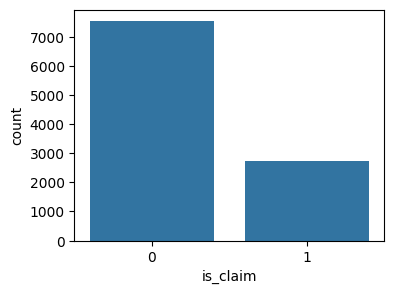

In [12]:
## separate features and labels
plt.figure(figsize=(4,3))

seed=213
X=df.drop(['is_claim'],axis=1)
y=df['is_claim']
sns.countplot(x=y,data=df)

### split data 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=seed)
training_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
print("training data size:",X_train.shape,y_train.shape)
print("test data size:",X_test.shape,y_test.shape)

### 3. Pre-processing ###

#### 3.1 Handle missing data ####

##### 3.1.1 Training data #####

In [48]:
training_df.isnull().sum()

num_young_drivers              0
age                            6
num_of_children                0
years_job_held_for           412
income                       436
single_parent                  0
value_of_home                458
married                        0
gender                         0
highest_education              0
occupation                   500
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
new_claim_value                0
vehicle_age                  478
address_type                   0
is_claim                       0
dtype: int64

In [49]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7726 entries, 7651 to 3371
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_young_drivers          7726 non-null   int64  
 1   age                        7720 non-null   float64
 2   num_of_children            7726 non-null   int64  
 3   years_job_held_for         7314 non-null   float64
 4   income                     7290 non-null   Int64  
 5   single_parent              7726 non-null   object 
 6   value_of_home              7268 non-null   Int64  
 7   married                    7726 non-null   object 
 8   gender                     7726 non-null   object 
 9   highest_education          7726 non-null   object 
 10  occupation                 7226 non-null   object 
 11  commute_dist               7726 non-null   int64  
 12  type_of_use                7726 non-null   object 
 13  vehicle_value              7726 non-null   Int64  

*Numeric and categorical data needs to be imputed differently, for numeric data we use KNN imputation, for categorical simple imputation*

In [50]:
# Define the numerical columns
numerical_cols_df = training_df.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorial columns for use later
cat_cols_df = training_df.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [51]:
# KNN imputer for numerical data
knn_imputer = KNNImputer(n_neighbors=5)

# Define function to impute num features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute numerical values with knn
num_data_imputed = num_knn_impute(training_df, numerical_cols, knn_imputer)
num_data_imputed.head();

In [52]:
# Simple imputer for categorical data
simple_imputer = SimpleImputer(strategy='most_frequent')

# Define function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute missing categorical values
cat_data_imputed = cat_simple_imputer(training_df, cat_cols, simple_imputer)
cat_data_imputed.head();

In [53]:
# Rejoin dfs
training_imputed_df = pd.concat([num_data_imputed, cat_data_imputed], axis=1)
# Check head
training_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,new_claim_value,vehicle_age,is_claim,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,43.0,0.0,11.0,1852.0,0.0,17.0,5800.0,4.0,0.0,0.0,1.0,0.0,7.0,0.0,No,Yes,F,<High School,Student,Private,Sports Car,No,Highly Rural/ Rural
1,0.0,35.0,0.0,11.4,73106.0,257856.0,6.0,20680.0,10.0,0.0,0.0,7.0,0.0,13.0,0.0,No,Yes,M,PhD,Blue Collar,Commercial,Van,Yes,Highly Urban/ Urban
2,0.0,38.0,0.0,7.0,33237.0,139952.0,21.0,15450.0,1.0,2588.0,1.0,7.0,0.0,1.0,0.0,No,Yes,F,High School,Clerical,Private,SUV,No,Highly Urban/ Urban
3,0.0,55.0,0.0,10.0,54877.0,0.0,37.0,42170.0,6.0,0.0,0.0,0.0,1125.0,8.0,1.0,No,No,M,Bachelors,Clerical,Commercial,Panel Truck,Yes,Highly Urban/ Urban
4,2.0,45.0,3.0,14.0,60769.0,218782.0,28.0,8310.0,11.0,0.0,0.0,3.0,0.0,10.0,0.0,No,Yes,M,Bachelors,Manager,Private,Minivan,No,Highly Urban/ Urban


##### 3.1.1 Test data #####

In [54]:
test_df.isnull().sum()

num_young_drivers              0
age                            1
num_of_children                0
years_job_held_for           136
income                       134
single_parent                  0
value_of_home                117
married                        0
gender                         0
highest_education              0
occupation                   165
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
new_claim_value                0
vehicle_age                  161
address_type                   0
is_claim                       0
dtype: int64

In [55]:
# Define the numerical columns
numerical_cols_df = test_df.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorial columns for use later
cat_cols_df = test_df.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

# Run the function to impute numerical values with knn
num_data_imputed = num_knn_impute(test_df, numerical_cols, knn_imputer)

# Run the function to impute missing categorical values
cat_data_imputed = cat_simple_imputer(test_df, cat_cols, simple_imputer)

# Rejoin dfs
test_imputed_df = pd.concat([num_data_imputed, cat_data_imputed], axis=1)
# Check head
test_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,new_claim_value,vehicle_age,is_claim,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,42.0,0.0,13.0,48305.0,193615.0,23.0,24520.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0,No,No,M,Bachelors,Clerical,Commercial,Panel Truck,No,Highly Urban/ Urban
1,0.0,51.0,0.0,8.0,74003.0,249395.0,29.0,31780.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,No,Yes,M,High School,Blue Collar,Commercial,Panel Truck,No,Highly Rural/ Rural
2,0.0,59.0,0.0,10.0,32857.0,0.0,29.0,34470.0,1.0,0.0,0.0,0.0,0.0,20.0,0.0,No,No,F,PhD,Home Maker,Private,Pickup,No,Highly Rural/ Rural
3,0.0,49.0,0.0,12.0,45471.0,170808.0,14.0,10670.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0,No,Yes,F,Bachelors,Clerical,Private,SUV,No,Highly Urban/ Urban
4,0.0,54.0,0.0,13.0,24397.0,143227.0,35.0,15240.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,No,Yes,M,High School,Clerical,Private,Minivan,No,Highly Urban/ Urban


#### 3.2 Handling Categorical Data ####

##### 3.2.1 Transformations for training set #####

In [56]:
## lsit categorical variables 
print('BINARY VARIABLES:', training_imputed_df['single_parent'].unique(),training_imputed_df['married'].unique(),
      training_imputed_df['gender'].unique(),training_imputed_df['type_of_use'].unique(),
      training_imputed_df['licence_revoked'].unique(),training_imputed_df['address_type'].unique())
print('ORDINAL VARIABLES:', training_imputed_df['highest_education'].unique())
print('Other categorical variables', training_imputed_df['occupation'].unique(), training_imputed_df['vehicle_type'].unique())

BINARY VARIABLES: ['No' 'Yes'] ['Yes' 'No'] ['F' 'M'] ['Private' 'Commercial'] ['No' 'Yes'] ['Highly Rural/ Rural' 'Highly Urban/ Urban']
ORDINAL VARIABLES: ['<High School' 'PhD' 'High School' 'Bachelors' 'Masters']
Other categorical variables ['Student' 'Blue Collar' 'Clerical' 'Manager' 'Doctor' 'Professional'
 'Home Maker' 'Lawyer'] ['Sports Car' 'Van' 'SUV' 'Panel Truck' 'Minivan' 'Pickup']


In [57]:
# different categories have to be transformed differently
#binary transform

bin_col=['single_parent','married','gender','type_of_use','licence_revoked','address_type']

# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'F': 1,
           'M': 0,
           'Highly Rural/ Rural':0,
           'Highly Urban/ Urban':1,
           'Private':0,
           'Commercial':1
           }

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data
    
# Call function
training_imputed_df = binarise_values(training_imputed_df, bin_col, mapping)
training_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,new_claim_value,vehicle_age,is_claim,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,43.0,0.0,11.0,1852.0,0.0,17.0,5800.0,4.0,0.0,0.0,1.0,0.0,7.0,0.0,0,1,1,<High School,Student,0,Sports Car,0,0
1,0.0,35.0,0.0,11.4,73106.0,257856.0,6.0,20680.0,10.0,0.0,0.0,7.0,0.0,13.0,0.0,0,1,0,PhD,Blue Collar,1,Van,1,1
2,0.0,38.0,0.0,7.0,33237.0,139952.0,21.0,15450.0,1.0,2588.0,1.0,7.0,0.0,1.0,0.0,0,1,1,High School,Clerical,0,SUV,0,1
3,0.0,55.0,0.0,10.0,54877.0,0.0,37.0,42170.0,6.0,0.0,0.0,0.0,1125.0,8.0,1.0,0,0,0,Bachelors,Clerical,1,Panel Truck,1,1
4,2.0,45.0,3.0,14.0,60769.0,218782.0,28.0,8310.0,11.0,0.0,0.0,3.0,0.0,10.0,0.0,0,1,0,Bachelors,Manager,0,Minivan,0,1


In [58]:
#onehot and ordinal transform

ord_col=['highest_education']
ohe_col=['occupation','vehicle_type']

education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)

#Define onehot encoder
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [59]:
# Transform training set 

numerical_cols_df = training_imputed_df.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()
cat_cols_df=training_imputed_df.select_dtypes(include=['object'])

# Encode ordinals and create dfs
ord_encoded = ord_encoder.fit_transform(cat_cols_df[ord_col])
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = ord_col

# One-hot encoding
one_hot_encoded = ohe_encoder.fit_transform(cat_cols_df[ohe_col])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = ohe_encoder.get_feature_names_out()

one_hot_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7726 entries, 0 to 7725
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   occupation_Blue Collar    7726 non-null   float64
 1   occupation_Clerical       7726 non-null   float64
 2   occupation_Doctor         7726 non-null   float64
 3   occupation_Home Maker     7726 non-null   float64
 4   occupation_Lawyer         7726 non-null   float64
 5   occupation_Manager        7726 non-null   float64
 6   occupation_Professional   7726 non-null   float64
 7   occupation_Student        7726 non-null   float64
 8   vehicle_type_Minivan      7726 non-null   float64
 9   vehicle_type_Panel Truck  7726 non-null   float64
 10  vehicle_type_Pickup       7726 non-null   float64
 11  vehicle_type_SUV          7726 non-null   float64
 12  vehicle_type_Sports Car   7726 non-null   float64
 13  vehicle_type_Van          7726 non-null   float64
dtypes: float

In [60]:
# Join encoded dfs to a single df and show head
training_df_encoded = pd.concat([numerical_cols_df,ord_encoded_df,one_hot_encoded_df], axis=1)
training_df_encoded
training_df_encoded.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,new_claim_value,vehicle_age,is_claim,single_parent,married,gender,type_of_use,licence_revoked,address_type,highest_education,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,43.0,0.0,11.0,1852.0,0.0,17.0,5800.0,4.0,0.0,0.0,1.0,0.0,7.0,0.0,0,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,35.0,0.0,11.4,73106.0,257856.0,6.0,20680.0,10.0,0.0,0.0,7.0,0.0,13.0,0.0,0,1,0,1,1,1,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,38.0,0.0,7.0,33237.0,139952.0,21.0,15450.0,1.0,2588.0,1.0,7.0,0.0,1.0,0.0,0,1,1,0,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,55.0,0.0,10.0,54877.0,0.0,37.0,42170.0,6.0,0.0,0.0,0.0,1125.0,8.0,1.0,0,0,0,1,1,1,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2.0,45.0,3.0,14.0,60769.0,218782.0,28.0,8310.0,11.0,0.0,0.0,3.0,0.0,10.0,0.0,0,1,0,0,0,1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [61]:
training_df_encoded.info()
X_train_encoded=training_df_encoded.drop(['is_claim'],axis=1)
y_train_encoded=training_df_encoded['is_claim']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7726 entries, 0 to 7725
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_young_drivers          7726 non-null   float64
 1   age                        7726 non-null   float64
 2   num_of_children            7726 non-null   float64
 3   years_job_held_for         7726 non-null   float64
 4   income                     7726 non-null   float64
 5   value_of_home              7726 non-null   float64
 6   commute_dist               7726 non-null   float64
 7   vehicle_value              7726 non-null   float64
 8   policy_tenure              7726 non-null   float64
 9   5_year_total_claims_value  7726 non-null   float64
 10  5_year_num_of_claims       7726 non-null   float64
 11  license_points             7726 non-null   float64
 12  new_claim_value            7726 non-null   float64
 13  vehicle_age                7726 non-null   float

##### 3.2.2 Transformations for test set #####

In [62]:
# binarise
test_imputed_df = binarise_values(test_imputed_df, bin_col, mapping)

# Separate numeric and categorical columns
numerical_cols_test_df = test_imputed_df.select_dtypes(include=['number'])
cat_cols_test_df=test_imputed_df.select_dtypes(include=['object'])

# Encode ordinals and create dfs
ord_encoded = ord_encoder.fit_transform(cat_cols_test_df[ord_col])
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = ord_col

# One-hot encoding
one_hot_encoded = ohe_encoder.fit_transform(cat_cols_test_df[ohe_col])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = ohe_encoder.get_feature_names_out()

# Join encoded dfs to a single df and show head
test_df_encoded = pd.concat([numerical_cols_test_df,ord_encoded_df,one_hot_encoded_df], axis=1)
test_df_encoded.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,new_claim_value,vehicle_age,is_claim,single_parent,married,gender,type_of_use,licence_revoked,address_type,highest_education,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,42.0,0.0,13.0,48305.0,193615.0,23.0,24520.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0,0,0,0,1,0,1,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,51.0,0.0,8.0,74003.0,249395.0,29.0,31780.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,0,1,0,1,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,59.0,0.0,10.0,32857.0,0.0,29.0,34470.0,1.0,0.0,0.0,0.0,0.0,20.0,0.0,0,0,1,0,0,0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,49.0,0.0,12.0,45471.0,170808.0,14.0,10670.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0,0,1,1,0,0,1,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,54.0,0.0,13.0,24397.0,143227.0,35.0,15240.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [70]:
#test_df_encoded.info()
X_test_encoded=test_df_encoded.drop(['is_claim'],axis=1)
y_test_encoded=test_df_encoded['is_claim']

#### 3.3 Data Imbalances (training data) ####

is_claim
0.0    5632
1.0    2094
Name: count, dtype: int64


<Axes: ylabel='count'>

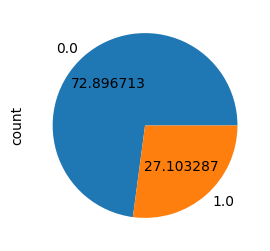

In [71]:
### check for data imbalances ###

plt.figure(figsize=(4,3))

print(y_train_encoded.value_counts())
y_train_encoded.value_counts().plot.pie(autopct='%2f')

Resampled dataset saved successfully.


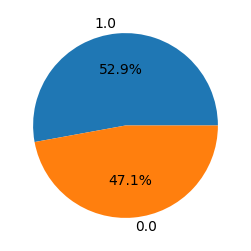

is_claim
1.0    4539
0.0    4047
Name: count, dtype: int64


In [72]:
#Apply SMOTEENN to balance dataset

from imblearn.combine import SMOTEENN
from sklearn.datasets import make_classification

plt.figure(figsize=(4,3))

# Apply SMOTEENN
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=seed)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_encoded, y_train_encoded)

# Combine the resampled features and target into a single DataFrame
feature_names=X_train_encoded.columns.to_list()
training_df_resampled = pd.DataFrame(X_train_resampled, columns=feature_names)
training_df_resampled['is_claim'] = y_train_resampled


print("Resampled dataset saved successfully.")
# Plot the value counts of the resampled target variable as a pie chart
training_df_resampled['is_claim'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')  # To remove the y-label
plt.show()
print(training_df_resampled['is_claim'].value_counts())

### 4. Exploratory Data Analysis ###

#### 4.1 Check correlations and distributions ####

<Axes: >

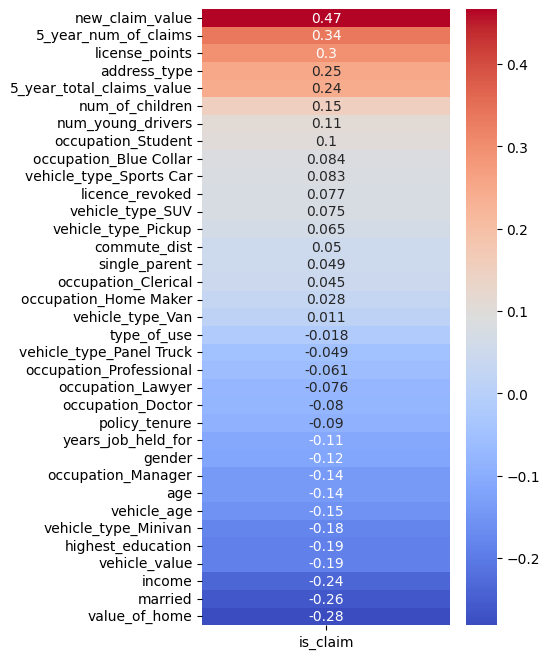

In [73]:
fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = training_df_resampled.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap='coolwarm', annot=True)

*It is obvious that the output 'is_claim' has high correlation with 'new_claim_value', any non-zero 'new_claim_value' corresponds to a claim* 

*So we drop this column for the classification problem, this is to be used for the regression part*

In [74]:
X_train_cleaned=training_df_resampled.drop(['is_claim','new_claim_value'],axis=1)
X_test_cleaned=test_df_encoded.drop(['is_claim','new_claim_value'],axis=1)

### 5. Model Building ###

#### 5.1 compare classification models ####

In [42]:
# Define the classifiers to test
clfs = [
    ('Log_reg', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decs_tr', DecisionTreeClassifier()),
    ('Rand_for', RandomForestClassifier(random_state=seed)),
    ('LinSVM', LinearSVC(random_state=seed, max_iter=1000, dual='auto')),
    ('XGBoost', XGBClassifier(random_state=seed)),
    ('AdaBoost', AdaBoostClassifier(random_state=seed, algorithm='SAMME')),
    ('Grad_Boost', GradientBoostingClassifier(random_state=seed)),
    ('Bagging', BaggingClassifier(random_state=seed)),
]

Text(0.5, 1.0, 'Cross-Validation Scores for Different Classifiers')

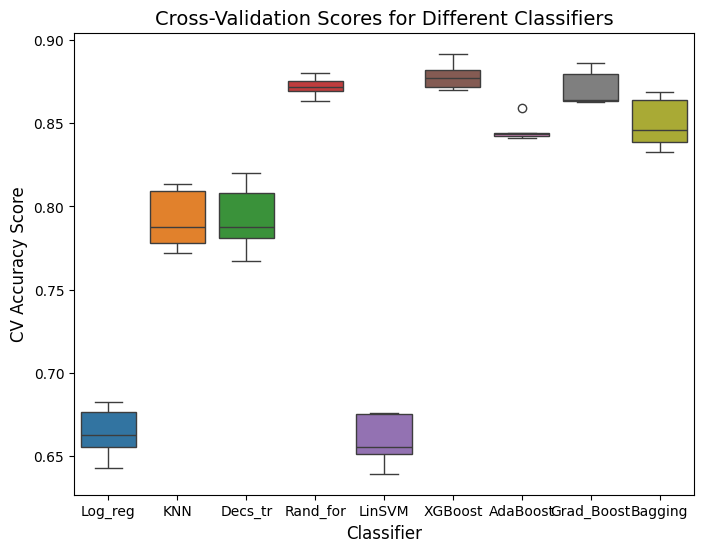

In [75]:
# Create KFold object with 10 folds
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Dictionary to store results
results = {}

# Evaluate each classifier using cross-validation
for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train_resampled, cv=kf)
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

# Plot scores
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(cv_scores_df)

# Add axis labels
ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('CV Accuracy Score', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Classifiers', fontsize=14)

#### We will proceed with Random Forest, XGBoost, and GradientBoost ####

#### 5.2 Hyperparameter optimzation ####

In [79]:
##hyperparameter optimization random search with XGBoost 

#choose model
xgb=XGBClassifier(random_state=seed,objective='binary:logistic')

#Define search space
search_space = {
    'n_estimators': randint(low=1, high=300),
    'learning_rate':uniform(0.01, 0.3),
    'max_depth': randint(low=1, high = 20),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'min_child_weight': randint(low=1, high= 20),
    'reg_alpha': randint(low=0, high=100),
    'reg_lambda':randint(low=0, high=10),
    'gamma': uniform(0, 1),
}

random = RandomizedSearchCV(xgb,param_distributions=search_space,cv=10,scoring='f1_weighted', n_jobs=-1,n_iter=200)
random.fit(X_train_cleaned, y_train_resampled)

print("RANDOM SEARCH")
print('RandomSearchCV Best hyperparameters:', random.best_params_)
print('RandomSearchCV Best score:', random.best_score_)

# Evaluate the best model from GridSearchCV on the test set
best_model = random.best_estimator_
random_accuracy = accuracy_score(y_true=y_test_encoded, y_pred=best_model.predict(X_test_cleaned))
print('RandomSearchCV Test set accuracy:', random_accuracy)
print('RandomSearchCV Classification Report:')
print(classification_report(y_true=y_test_encoded, y_pred=best_model.predict(X_test_cleaned)))

RANDOM SEARCH
RandomSearchCV Best hyperparameters: {'colsample_bytree': 0.20288939705992437, 'gamma': 0.7462168347598116, 'learning_rate': 0.15245266738902383, 'max_depth': 17, 'min_child_weight': 11, 'n_estimators': 276, 'reg_alpha': 2, 'reg_lambda': 0, 'subsample': 0.8488192186409664}
RandomSearchCV Best score: 0.8657653837473431
RandomSearchCV Test set accuracy: 0.781832298136646
RandomSearchCV Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86      1924
         1.0       0.58      0.52      0.55       652

    accuracy                           0.78      2576
   macro avg       0.71      0.70      0.70      2576
weighted avg       0.78      0.78      0.78      2576



*L1 Regularization is implemented via reg_alpha=2 parameter*

In [83]:
##### Grid search 

#choose model
xgb=XGBClassifier(random_state=seed,min_child_weight= 11, objective='binary:logistic')

search_space={'n_estimators':[i for i in range(275,280)],
              'max_depth':[i for i in range(15,20)],
              'learning_rate':[0.14,0.15,0.16,0.17],
              'colsample_bytree':[0.20288939705992437],
              'gamma': [0.7462168347598116],
              'reg_alpha': [2],
              'reg_lambda': [0], 
              'subsample': [0.848819218641]           
           }

grid = GridSearchCV(xgb,param_grid=search_space,cv=5,scoring='accuracy', n_jobs=-1)
grid.fit(X_train_cleaned, y_train_resampled)

print("GRID SEARCH")
print('GridSearchCV Best hyperparameters:', grid.best_params_)
print('GridSearchCV Best score:', grid.best_score_)

# Evaluate the best model from GridSearchCV on the test set
best_model = grid.best_estimator_
grid_accuracy = accuracy_score(y_true=y_test_encoded, y_pred=best_model.predict(X_test_cleaned))
print('GridSearchCV Test set accuracy:', grid_accuracy)
print('GridSearchCV Classification Report:')
print(classification_report(y_true=y_test_encoded, y_pred=best_model.predict(X_test_cleaned)))

/Users/riyanandi/Desktop/ML/nlpenv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GRID SEARCH
GridSearchCV Best hyperparameters: {'colsample_bytree': 0.20288939705992437, 'gamma': 0.7462168347598116, 'learning_rate': 0.17, 'max_depth': 16, 'n_estimators': 275, 'reg_alpha': 2, 'reg_lambda': 0, 'subsample': 0.848819218641}
GridSearchCV Best score: 0.8589792006660776
GridSearchCV Test set accuracy: 0.7833850931677019
GridSearchCV Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86      1924
         1.0       0.58      0.52      0.55       652

    accuracy                           0.78      2576
   macro avg       0.71      0.70      0.70      2576
weighted avg       0.78      0.78      0.78      2576



##### Precision and recall for class 1, which identifies correctly whether claim is made ot not, is very low. For this problem, the goal should be to make this higher  #####

Text(0.5, 1.0, 'Confusion Matrix on Training Data')

<Figure size 400x300 with 0 Axes>

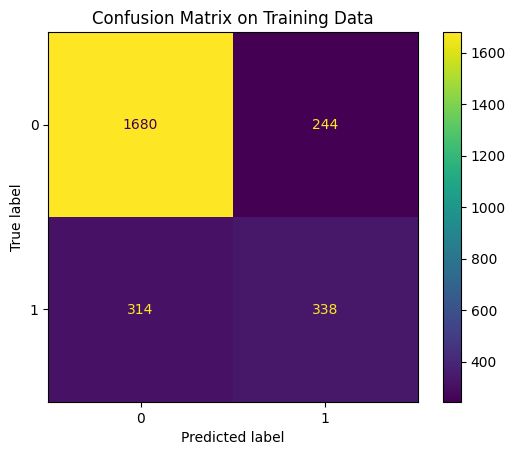

In [88]:
# Compute the confusion matrix
y_pred=best_model.predict(X_test_cleaned)
cm = confusion_matrix(y_test_encoded, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix on Training Data')

#### RandomForest ####

In [95]:
##hyperparameter optimization random search with randomforest

#choose model
rf=RandomForestClassifier(random_state=seed)

# Define search space
search_space = {
    'n_estimators': randint(low=1, high=1000),  # Number of trees in the forest
    'max_depth': randint(low=1, high=20),         # Maximum depth of the tree
    'min_samples_split': randint(low=2, high=20), # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(low=1, high=20),  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt','log2'],            # Number of features to consider when looking for the best split
    'bootstrap': [True],                   # Whether bootstrap samples are used when building trees
    'criterion': ['gini', 'entropy'],             # Function to measure the quality of a split
    'max_samples': uniform(0.5, 0.5)              # If bootstrap=True, the number of samples to draw from X to train each base estimator
}

random = RandomizedSearchCV(rf,param_distributions=search_space,cv=10,scoring='f1_weighted', n_jobs=-1,n_iter=200)
random.fit(X_train_cleaned, y_train_resampled)

print("RANDOM SEARCH")
print('RandomSearchCV Best hyperparameters:', random.best_params_)
print('RandomSearchCV Best score:', random.best_score_)

# Evaluate the best model from RandomSearchCV on the test set
best_model = random.best_estimator_
random_accuracy = accuracy_score(y_true=y_test_encoded, y_pred=best_model.predict(X_test_cleaned))
print('RandomSearchCV Test set accuracy:', random_accuracy)
print('RandomSearchCV Classification Report:')
print(classification_report(y_true=y_test_encoded, y_pred=best_model.predict(X_test_cleaned)))

/Users/riyanandi/Desktop/ML/nlpenv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RANDOM SEARCH
RandomSearchCV Best hyperparameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 17, 'max_features': 'sqrt', 'max_samples': 0.8489419722345188, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 930}
RandomSearchCV Best score: 0.8672283316806627
RandomSearchCV Test set accuracy: 0.7628105590062112
RandomSearchCV Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      1924
         1.0       0.53      0.55      0.54       652

    accuracy                           0.76      2576
   macro avg       0.69      0.69      0.69      2576
weighted avg       0.77      0.76      0.76      2576



*RandomForest model is very slow, and it doesn't improve the scores as compared to XGBoost*

#### 5.3 Feature Importances ####

num_young_drivers: 0.018573087303466466
age: 0.04448433481321745
num_of_children: 0.05541210081319352
years_job_held_for: 0.033169094787929704
income: 0.05680836781772747
value_of_home: 0.056546514156190913
commute_dist: 0.044427997839409775
vehicle_value: 0.05188981250994535
policy_tenure: 0.033730755054085355
5_year_total_claims_value: 0.080097854128086
5_year_num_of_claims: 0.08277117911068688
license_points: 0.0708152986151794
vehicle_age: 0.03701043906854679
single_parent: 0.007835175108683739
married: 0.027399286976472124
gender: 0.011511241475475114
type_of_use: 0.00783133284009317
licence_revoked: 0.0061496518513892455
address_type: 0.03586263382026489
highest_education: 0.044237019381738026
occupation_Blue Collar: 0.022257436613637223
occupation_Clerical: 0.008303263489139064
occupation_Doctor: 0.0014991637833068271
occupation_Home Maker: 0.004816273590832278
occupation_Lawyer: 0.0069585047963461365
occupation_Manager: 0.01831986056618813
occupation_Professional: 0.01221688058

Text(0.5, 1.0, 'Feature Importance')

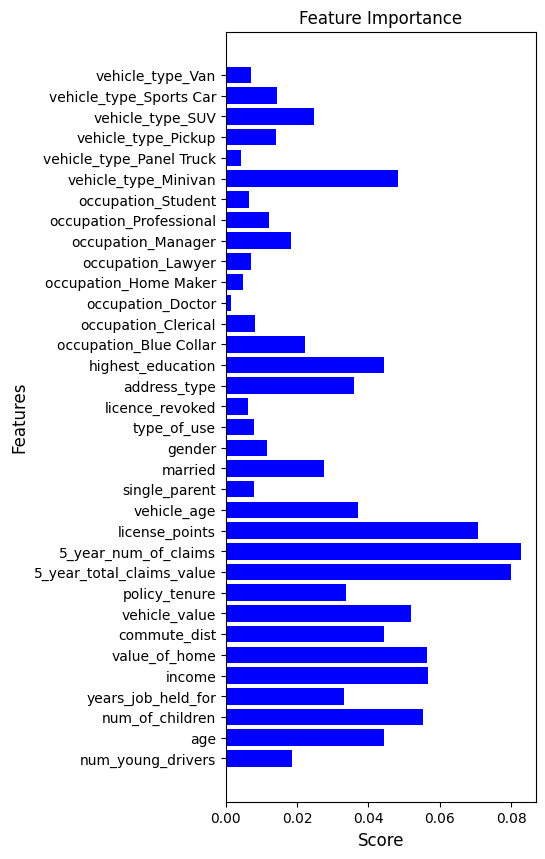

In [96]:
# Get feature importances
plt.figure(figsize=(4,10))

feature_importances = best_model.feature_importances_
feature_names = X_train_cleaned.columns

# Print feature importances
for name, importance in zip(feature_names, feature_importances):
    print(f'{name}: {importance}')

# Visualize feature importances
plt.barh(feature_names, feature_importances, color='blue')
plt.xlabel('Score',fontsize=12)
plt.ylabel('Features',fontsize=12)
plt.title('Feature Importance',fontsize=12)

In [ ]:
### Recursive feature elimination 

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold as KFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

results=[]

#best model
xgb=XGBClassifier(random_state=seed,min_child_weight= 11, objective='binary:logistic',
                  colsample_bytree=0.20288939705992437, gamma= 0.7462168347598116, 
                  learning_rate= 0.17, max_depth= 16, n_estimators=275, reg_alpha=2,
                  reg_lambda= 0, subsample= 0.848819218641)


# Define the range for the number of features
n_features_range = range(10, 30)
k = 5

# Loop over the range of features
for n_features in n_features_range:
    
    # Define the pipeline
    pipeline = Pipeline([
        ('feature_selection', RFE(estimator=xgb, n_features_to_select=n_features)),
        ('classification', DecisionTreeClassifier(max_depth=6,random_state=seed,
                                                  criterion='gini',splitter='best'))])
    
    # Define the cross-validation procedure
    cv = KFold(n_splits=k, random_state=seed, n_repeats=3)
    
    # Fit the pipeline to get the selected features
    pipeline.fit(X_train_resampled, y_train_resampled)
    selected_features = np.array(feature_names)[pipeline.named_steps['feature_selection'].support_]
    
    # Evaluate the pipeline with cross-validation
    scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy')
    
    # Store the results
    results.append((n_features, scores.mean(), scores.std(), selected_features))


# Convert the results to a DataFrame for better readability
results_df = pd.DataFrame(results, columns=['n_features', 'mean_accuracy', 'std_accuracy','selected_features'])

# Print the results
print(results_df)

#### voting classifier -does not imrpove model
from sklearn.ensemble import VotingClassifier

estimator = []
estimator.append(('DTC', DecisionTreeClassifier(random_state=seed,criterion='gini',splitter='best')))
estimator.append(('bag', BaggingClassifier(n_estimators=200, random_state=seed)))
estimator.append(('xgb', XGBClassifier(random_state=seed,learning_rate=0.17, objective='binary:logistic',max_depth=16,n_estimators=275)))
estimator.append(('KNN', KNeighborsClassifier()))


#Hard voting
#Hard = VotingClassifier(estimators = estimator, voting ='hard')
#Hard.fit(X_train_cleaned, y_train_resampled)
#y_pred = Hard.predict(X_test_cleaned)


#Soft voting
Soft = VotingClassifier(estimators = estimator, voting ='soft')
Soft.fit(X_train_cleaned, y_train_resampled)
y_pred =Soft.predict(X_test_cleaned)


score = accuracy_score(y_test_encoded, y_pred)
class_report = classification_report(y_test_encoded, y_pred)
print('score:',score)
print('classification report:')
print(class_report)

### Regression ###

In [114]:
training_df_reg=training_df_resampled[training_df_resampled['is_claim']==1]
training_df_reg.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,new_claim_value,vehicle_age,single_parent,married,gender,type_of_use,licence_revoked,address_type,highest_education,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van,is_claim
4047,0.0,44.0,2.0,0.0,0.0,0.0,39.0,23570.0,1.0,1380.0,3.0,3.0,3666.0,17.0,1,0,1,0,0,1,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4048,1.0,56.0,2.0,13.0,67783.0,245496.0,29.0,23520.0,5.0,0.0,0.0,4.0,58851.0,11.0,0,1,0,1,0,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4049,0.0,57.0,0.0,11.0,13235.0,135560.0,6.0,10170.0,4.0,8135.0,3.0,3.0,2422.0,13.0,0,0,1,0,0,1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4050,0.0,32.0,1.0,11.0,36179.0,106892.0,12.0,13030.0,1.0,0.0,0.0,0.0,4307.0,6.0,1,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4051,0.0,42.0,0.0,6.0,51695.0,0.0,29.0,17630.0,10.0,0.0,0.0,1.0,10453.0,1.0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [115]:
training_df_reg=training_df_reg.drop(['is_claim'],axis=1)
training_df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4539 entries, 4047 to 8585
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_young_drivers          4539 non-null   float64
 1   age                        4539 non-null   float64
 2   num_of_children            4539 non-null   float64
 3   years_job_held_for         4539 non-null   float64
 4   income                     4539 non-null   float64
 5   value_of_home              4539 non-null   float64
 6   commute_dist               4539 non-null   float64
 7   vehicle_value              4539 non-null   float64
 8   policy_tenure              4539 non-null   float64
 9   5_year_total_claims_value  4539 non-null   float64
 10  5_year_num_of_claims       4539 non-null   float64
 11  license_points             4539 non-null   float64
 12  new_claim_value            4539 non-null   float64
 13  vehicle_age                4539 non-null   float64

In [116]:
test_df_reg= test_df_encoded[test_df_encoded['is_claim']==1]
test_df_reg=test_df_reg.drop(['is_claim'],axis=1)
test_df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 652 entries, 7 to 2572
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_young_drivers          652 non-null    float64
 1   age                        652 non-null    float64
 2   num_of_children            652 non-null    float64
 3   years_job_held_for         652 non-null    float64
 4   income                     652 non-null    float64
 5   value_of_home              652 non-null    float64
 6   commute_dist               652 non-null    float64
 7   vehicle_value              652 non-null    float64
 8   policy_tenure              652 non-null    float64
 9   5_year_total_claims_value  652 non-null    float64
 10  5_year_num_of_claims       652 non-null    float64
 11  license_points             652 non-null    float64
 12  new_claim_value            652 non-null    float64
 13  vehicle_age                652 non-null    float64
 14

In [121]:
X_train=training_df_reg.drop(['new_claim_value'],axis=1)
y_train=training_df_reg['new_claim_value']
X_test=test_df_reg.drop(['new_claim_value'],axis=1)
y_test=test_df_reg['new_claim_value']
print(X_train.shape,X_test.shape)

(4539, 34) (652, 34)


In [128]:
regs = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=seed)),
    ('Random Forest', RandomForestRegressor(random_state=seed)),
    ('KNN Model ', KNeighborsRegressor()),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    ('XGBRegressor', XGBRegressor(random_state=seed))
]

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

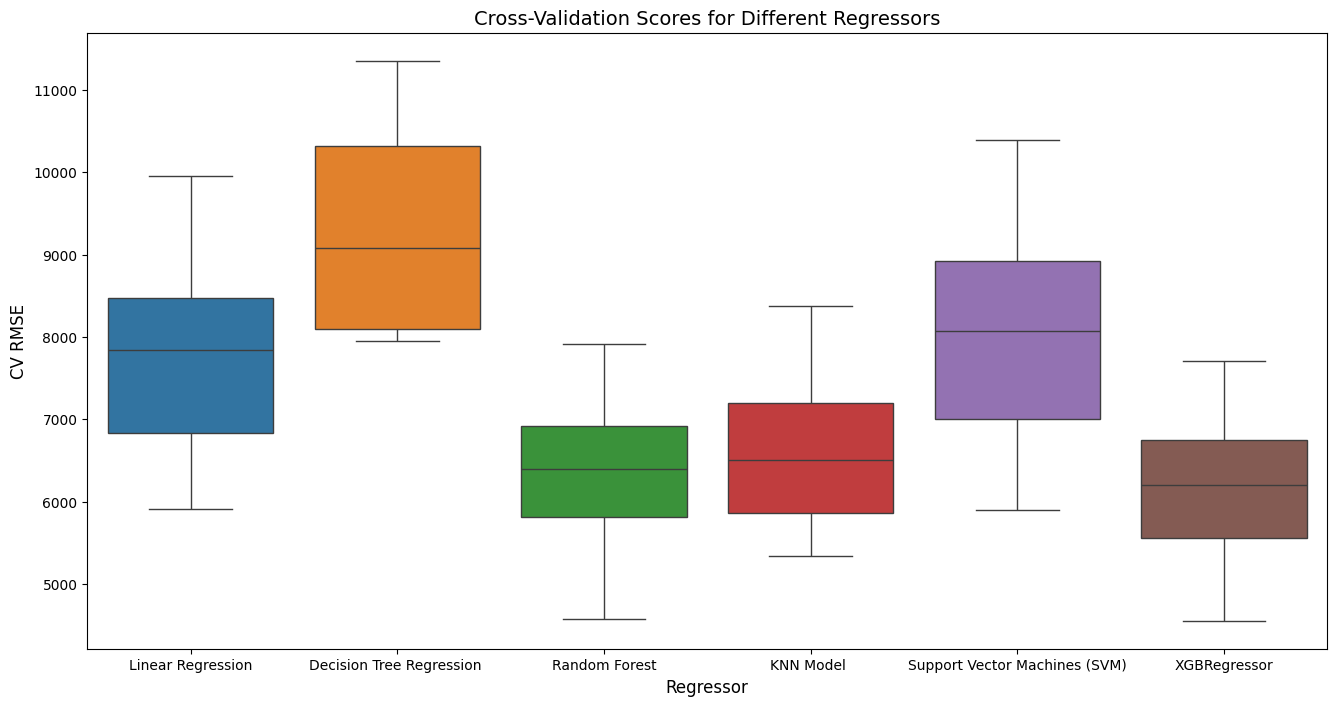

In [129]:
# Create KFold object with 10 folds
reg_kf = KFold(n_splits=10, shuffle=True, random_state=seed)

# Dictionary to store results
reg_results = {}

# Evaluate each classifier using cross-validation
for reg_name, reg in regs:
    cv_rmses = -cross_val_score(reg, X_train, y_train, cv=reg_kf, scoring='neg_root_mean_squared_error')
    reg_results[reg_name] = cv_rmses

reg_cv_scores_df = pd.DataFrame(reg_results)

# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_cv_scores_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)

RMSE: 9761.2697


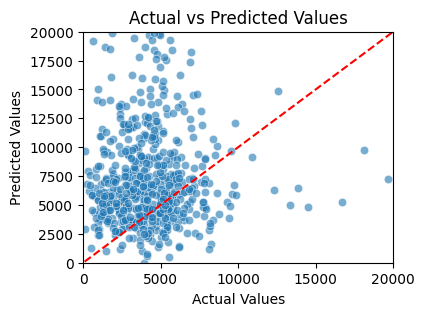

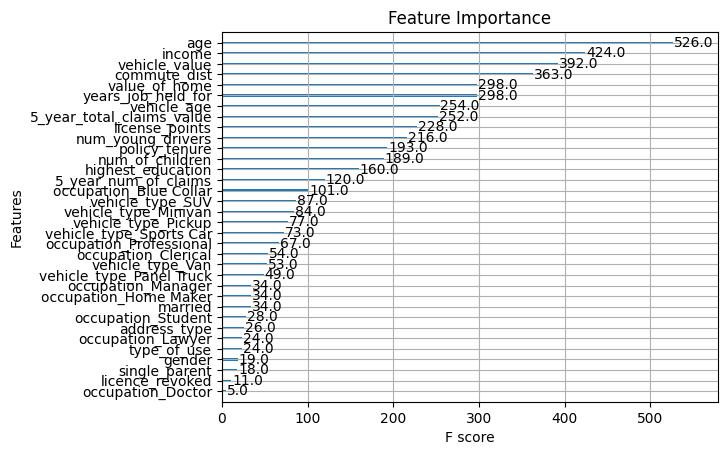

In [137]:
from xgboost import plot_importance

# Initialize the XGBoost Regressor with default parameters
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=seed)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

# Plot the predicted vs actual values
plt.figure(figsize=(4, 3))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlim(0,20000)
plt.ylim(0,20000)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

# Plot the feature importance
plot_importance(xgb_regressor, importance_type='weight')
plt.title("Feature Importance")
plt.show()